# Creating Adverse Outcome Pathway (AOP) networks for Lung, Liver, Kidney and Brain
Before starting, open Cytoscape on your system.

In [30]:
import sys

!{sys.executable} -m pip install --upgrade pip 
!{sys.executable} -m pip install watermark

try:
    from SPARQLWrapper import SPARQLWrapper, JSON
except ImportError:
    !{sys.executable} -m pip install sparqlwrapper
    from SPARQLWrapper import SPARQLWrapper, JSON

try:
    import pandas as pd
except ImportError:
    !{sys.executable} -m pip install pandas
    import pandas as pd
    
import matplotlib.pyplot as plt
%matplotlib inline

import py4cytoscape as p4c
p4c.cytoscape_ping()

import os
print('Get current working directory : ', os.getcwd())

from IPython.display import Image
from IPython.display import SVG

pd.set_option('display.max_colwidth', -1)

DEPRECATION: jwt 1.0.0 has a non-standard dependency specifier cryptography<3.*,>=2.2.2. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of jwt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pandas 0.24.2 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: jwt 1.0.0 has a non-standard dependency specifier cryptography<3.*,>=2.2.2. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of jwt or contact the author to suggest that they release a version with a conform

## Part 1: Open and explore input file
The input file `AOP-Wiki_AO_classification.tsv` is based on the SPARQL query listed below, with a manually added column to define the organ to which these AOPs are relevant. The classification by organ was based on the titles of Adverse Outcomes or, when these are not specific enough, the titles of intermediate Key Events.
SPARQL query executed on https://aopwiki.rdf.bigcat-bioinformatics.org/
```sparql
SELECT ?AOP ?AOPName ?ao ?aotitle  WHERE {
  ?AOP a aopo:AdverseOutcomePathway ; 
         dc:title ?AOPName ;
         aopo:has_adverse_outcome ?ao .
  ?ao a aopo:KeyEvent ; 
  dc:title ?aotitle .}
  ORDER BY ASC (?AOP)
```

In [2]:
df = pd.read_csv('AOP-Wiki_AO_classification.tsv', sep='\t')

In [3]:
df.head(10)

,AOP,AOPName,ao,aotitle,organ
0,https://identifiers.org/aop/1,Uncharacterized liver damage leading to hepatocellular carcinoma,https://identifiers.org/aop.events/334,"Promotion, Hepatocelluar carcinoma",Liver
1,https://identifiers.org/aop/10,Binding to the picrotoxin site of ionotropic GABA receptors leading to epileptic seizures in adult brain,https://identifiers.org/aop.events/613,"Occurrence, Epileptic seizure",Brain
2,https://identifiers.org/aop/100,Cyclooxygenase inhibition leading to reproductive dysfunction via inhibition of female spawning behavior,https://identifiers.org/aop.events/360,"Decrease, Population growth rate",Other
3,https://identifiers.org/aop/101,Cyclooxygenase inhibition leading to reproductive dysfunction via inhibition of pheromone release,https://identifiers.org/aop.events/360,"Decrease, Population growth rate",Other
4,https://identifiers.org/aop/102,Cyclooxygenase inhibition leading to reproductive dysfunction via interference with meiotic prophase I /metaphase I transition,https://identifiers.org/aop.events/360,"Decrease, Population growth rate",Other
5,https://identifiers.org/aop/103,Cyclooxygenase inhibition leading to reproductive dysfunction via interference with spindle assembly checkpoint,https://identifiers.org/aop.events/360,"Decrease, Population growth rate",Other
6,https://identifiers.org/aop/104,Altered ion channel activity leading impaired heart function,https://identifiers.org/aop.events/351,Increased Mortality,Other
7,https://identifiers.org/aop/105,Alpha2u-microglobulin cytotoxicity leading to renal tubular adenomas and carcinomas (in male rat),https://identifiers.org/aop.events/713,"Increase, Adenomas/carcinomas (renal tubular)",Kidney
8,https://identifiers.org/aop/106,Chemical binding to tubulin in oocytes leading to aneuploid offspring,https://identifiers.org/aop.events/728,"Increase, Aneuploid offspring",Other
9,https://identifiers.org/aop/107,Constitutive androstane receptor activation leading to hepatocellular adenomas and carcinomas in the mouse and the rat,https://identifiers.org/aop.events/719,"Increase, hepatocellular adenomas and carcinomas",Liver


### Gain insights into AOPs and AOs relevant for the organ systems

In [4]:
organdict = {}
for index, row in df.iterrows(): 
    if not row[4] in organdict:
        organdict[row[4]] = set()
    organdict[row[4]].add(row[0])

In [5]:
del(organdict['Other'])

In [6]:
for item in organdict:
    print(item,': ',len(organdict[item]))


Liver :  31
Brain :  39
Kidney :  16
Lung :  22


In [7]:
aotitles_by_organ = {}

# Iterate over unique values in the 'organ' column
for organ in df['organ'].unique():
    # Filter the DataFrame for the current organ
    organ_df = df[df['organ'] == organ]
    # Extract the 'aotitle' values for the current organ
    aotitles = organ_df['aotitle'].tolist()
    # Store the list of aotitles for the current organ in the dictionary
    aotitles_by_organ[organ] = aotitles

# Group by 'organ' and 'aotitle', then count the occurrences of each AO
frequency_df = df.groupby(['organ', 'aotitle']).size().reset_index(name='frequency')
frequency_df = frequency_df[frequency_df['organ'] != 'Other']

# Iterate over unique values in the 'organ' column
for organ in df['organ'].unique():
    # Filter the frequency DataFrame for the current organ
    organ_frequency_df = frequency_df[frequency_df['organ'] == organ]
    organ_frequency_df = organ_frequency_df.sort_values(by='frequency', ascending=False)
    # Print the DataFrame for the current organ
    print(f"Organ: {organ}")
    display(organ_frequency_df)
    organ_frequency_df.to_csv('output/'+organ+'-AOs.tsv', sep='\t', index=False, encoding='utf-8')


Organ: Liver


,organ,aotitle,frequency
33,Liver,"Increased, Liver Steatosis",6
32,Liver,"Increase, hepatocellular adenomas and carcinomas",5
38,Liver,"N/A, Liver fibrosis",3
36,Liver,Liver Injury,3
39,Liver,"N/A, Steatohepatisis",2
34,Liver,"Increased, steatosis",1
40,Liver,"Promotion, Hepatocelluar carcinoma",1
37,Liver,"N/A, Liver Steatosis",1
35,Liver,Liver Cancer,1
25,Liver,"Accumulation, Liver lipid",1


Organ: Brain


,organ,aotitle,frequency
2,Brain,"Cognitive Function, Decreased",6
4,Brain,"Impairment, Learning and memory",6
0,Brain,Anti-depressant Activity,2
10,Brain,"Increased, epilepsy",2
17,Brain,Parkinsonian motor deficits,2
14,Brain,Neural tube defects,2
13,Brain,"N/A, Neurodegeneration",2
11,Brain,"Increased, seizure",2
9,Brain,"Increased, depression",2
8,Brain,"Increased, agitation",2


Organ: Other


,organ,aotitle,frequency


Organ: Kidney


,organ,aotitle,frequency
24,Kidney,"Occurrence, Kidney toxicity",5
22,Kidney,Increased Mortality,4
20,Kidney,Chronic kidney disease,2
21,Kidney,"Increase, Adenomas/carcinomas (renal tubular)",2
23,Kidney,"Increased, Kidney Failure",2
19,Kidney,Chemical induced Fanconi syndrome,1


Organ: Lung


,organ,aotitle,frequency
44,Lung,"Decrease, Lung function",6
50,Lung,Lung fibrosis,3
51,Lung,Pulmonary fibrosis,3
48,Lung,"Increased, mesotheliomas",2
49,Lung,Lung cancer,2
42,Lung,Bronchiolitis obliterans,1
43,Lung,Chronic obstructive pulmonary disease,1
45,Lung,"Increase, Adenomas/carcinomas (bronchioloalveolar)",1
46,Lung,"Increase, lung cancer",1
47,Lung,Increased Mortality,1


## Part 2: Create AOP networks in Cytoscape
Using the AOP-Wiki SPARQL endpoint, all KEs and KERs are extracted, from which the networks are built using the Py4Cytoscape library is used. 

In [8]:
AOPWikiSPARQL = SPARQLWrapper("https://aopwiki.rdf.bigcat-bioinformatics.org/sparql/")
AOPWikiSPARQL.setReturnFormat(JSON) 

### Define functions for visualisations

In [28]:
def update_bar_chart(value, chart_data,organ):
    if value in chart_data:
        chart_data[value] += 1
    else:
        chart_data[value] = 1
    
    plt.bar(chart_data.keys(), chart_data.values())
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.xlim(0, 30)
    plt.title('Bar Chart of Frequency - ' + str(organ))
    
def show_image_in_notebook(filename):
    p4c.export_image(filename, type="SVG")
    p4c.sandbox_get_from(filename)
    return SVG(filename)



### Network creation and extracting numbers

Liver
The AOP  https://identifiers.org/aop/60  has 15 KERs
The AOP  https://identifiers.org/aop/117  has 3 KERs
The AOP  https://identifiers.org/aop/118  has 3 KERs
The AOP  https://identifiers.org/aop/213  has 5 KERs
The AOP  https://identifiers.org/aop/318  has 4 KERs
The AOP  https://identifiers.org/aop/46  has 8 KERs
The AOP  https://identifiers.org/aop/130  has 25 KERs
The AOP  https://identifiers.org/aop/232  has 7 KERs
The AOP  https://identifiers.org/aop/144  has 8 KERs
The AOP  https://identifiers.org/aop/383  has 5 KERs
The AOP  https://identifiers.org/aop/209  has 8 KERs
The AOP  https://identifiers.org/aop/61  has 9 KERs
The AOP  https://identifiers.org/aop/57  has 17 KERs
The AOP  https://identifiers.org/aop/423  has 1 KERs
The AOP  https://identifiers.org/aop/38  has 7 KERs
The AOP  https://identifiers.org/aop/278  has 7 KERs
The AOP  https://identifiers.org/aop/285  has 6 KERs
The AOP  https://identifiers.org/aop/36  has 7 KERs
The AOP  https://identifiers.org/aop/362  h

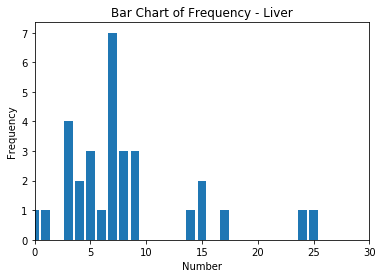

Number of KERs for AOP network of Liver: 233
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


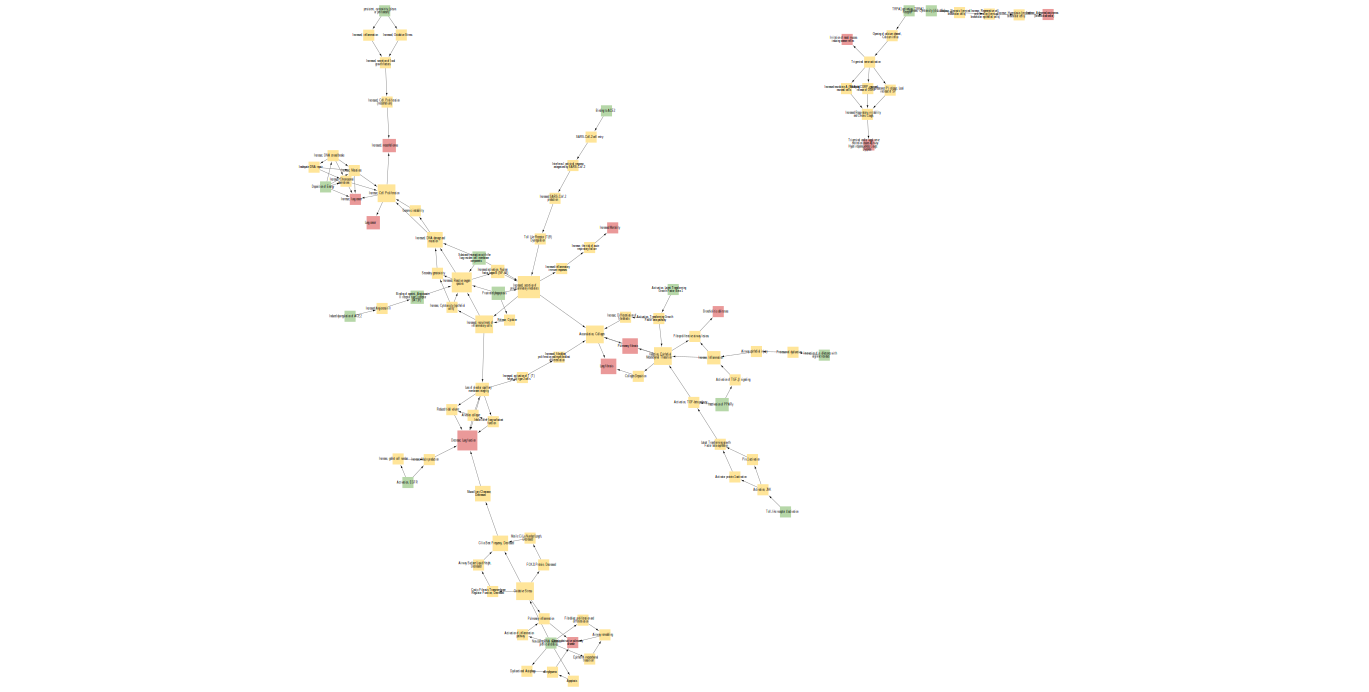

Brain
The AOP  https://identifiers.org/aop/222  has 10 KERs
The AOP  https://identifiers.org/aop/48  has 10 KERs
The AOP  https://identifiers.org/aop/260  has 8 KERs
The AOP  https://identifiers.org/aop/65  has 6 KERs
The AOP  https://identifiers.org/aop/221  has 9 KERs
The AOP  https://identifiers.org/aop/395  has 0 KERs
The AOP  https://identifiers.org/aop/10  has 5 KERs
The AOP  https://identifiers.org/aop/235  has 4 KERs
The AOP  https://identifiers.org/aop/169  has 7 KERs
The AOP  https://identifiers.org/aop/279  has 3 KERs
The AOP  https://identifiers.org/aop/225  has 9 KERs
The AOP  https://identifiers.org/aop/223  has 7 KERs
The AOP  https://identifiers.org/aop/449  has 7 KERs
The AOP  https://identifiers.org/aop/214  has 26 KERs
The AOP  https://identifiers.org/aop/450  has 6 KERs
The AOP  https://identifiers.org/aop/17  has 11 KERs
The AOP  https://identifiers.org/aop/230  has 9 KERs
The AOP  https://identifiers.org/aop/374  has 4 KERs
The AOP  https://identifiers.org/aop/215

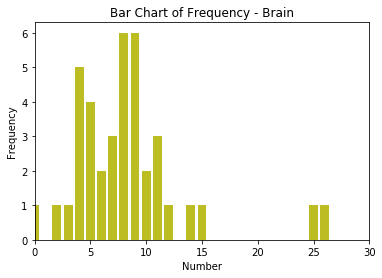

Number of KERs for AOP network of Brain: 239
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


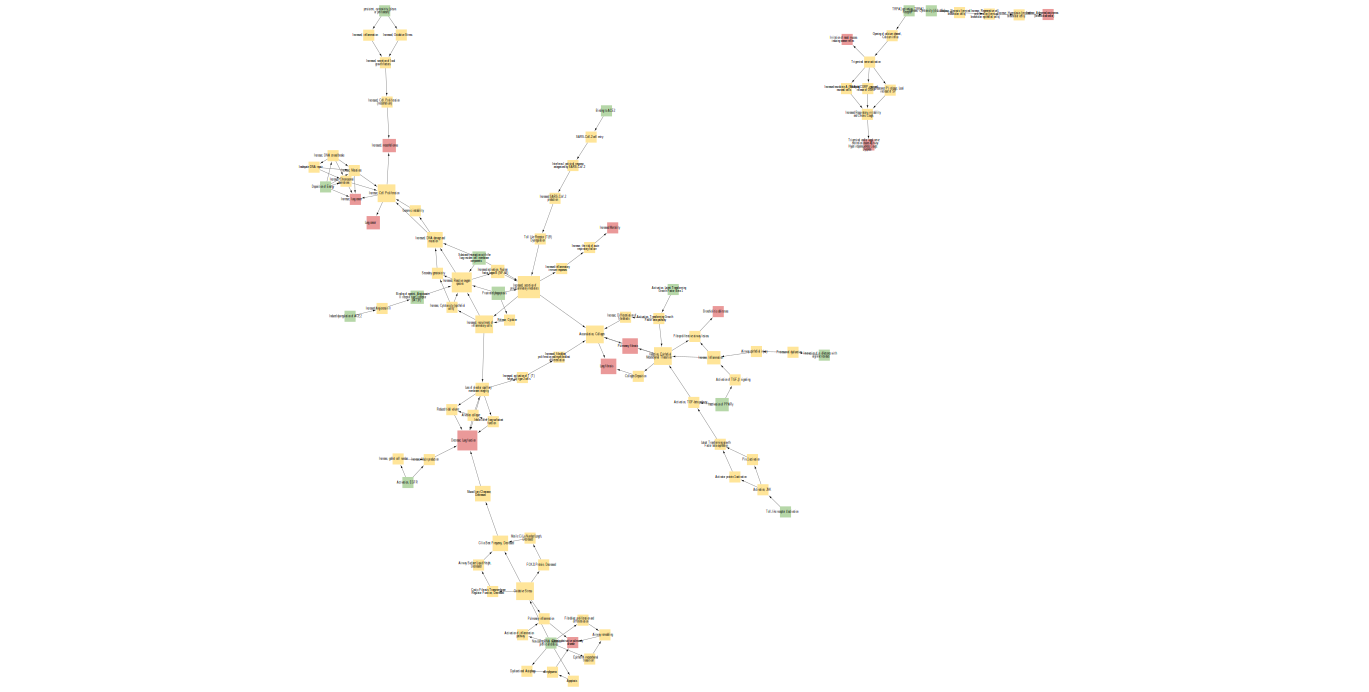

Kidney
The AOP  https://identifiers.org/aop/258  has 4 KERs
The AOP  https://identifiers.org/aop/257  has 4 KERs
The AOP  https://identifiers.org/aop/138  has 9 KERs
The AOP  https://identifiers.org/aop/413  has 5 KERs
The AOP  https://identifiers.org/aop/256  has 4 KERs
The AOP  https://identifiers.org/aop/284  has 0 KERs
The AOP  https://identifiers.org/aop/33  has 2 KERs
The AOP  https://identifiers.org/aop/116  has 3 KERs
The AOP  https://identifiers.org/aop/276  has 5 KERs
The AOP  https://identifiers.org/aop/177  has 11 KERs
The AOP  https://identifiers.org/aop/384  has 5 KERs
The AOP  https://identifiers.org/aop/186  has 6 KERs
The AOP  https://identifiers.org/aop/447  has 14 KERs
The AOP  https://identifiers.org/aop/128  has 24 KERs
The AOP  https://identifiers.org/aop/105  has 5 KERs
The AOP  https://identifiers.org/aop/437  has 4 KERs
Number of KEs in network of Kidney: 66


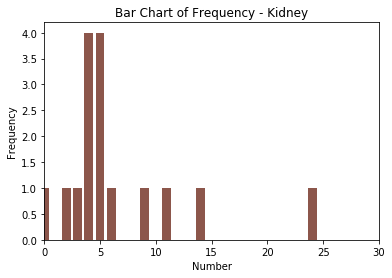

Number of KERs for AOP network of Kidney: 89
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


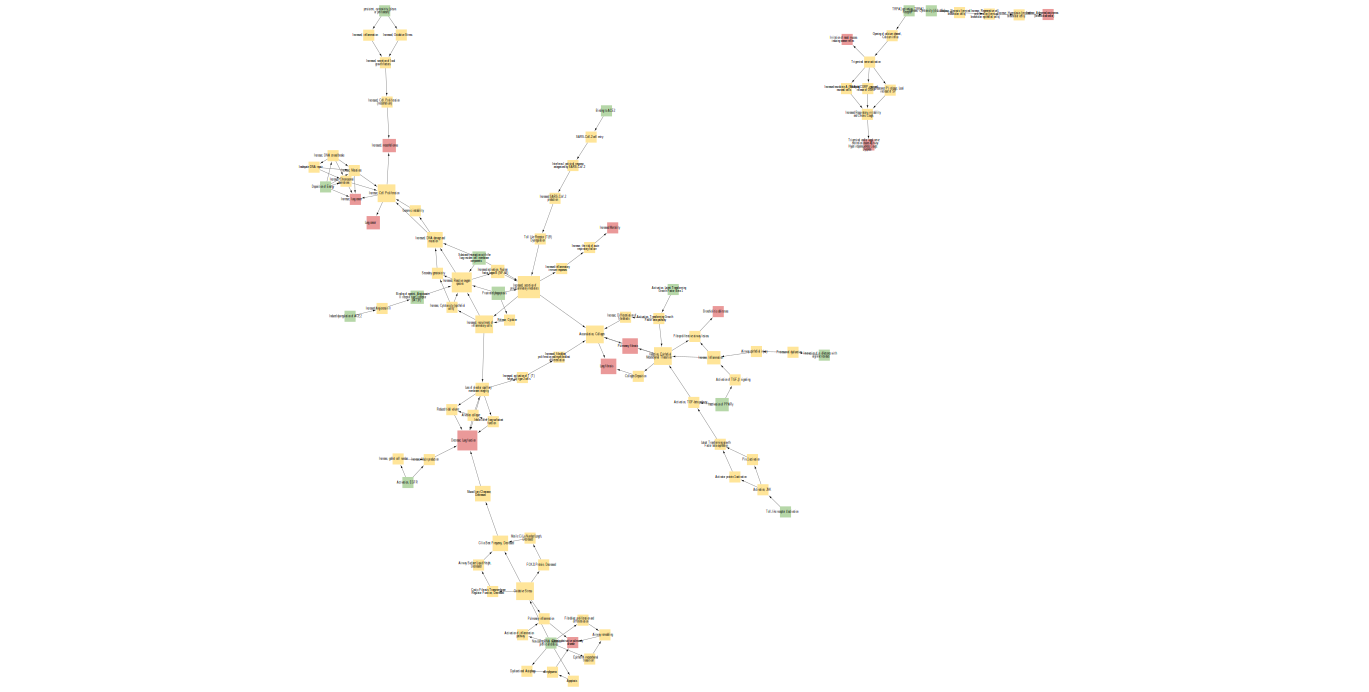

Lung
The AOP  https://identifiers.org/aop/302  has 9 KERs
The AOP  https://identifiers.org/aop/109  has 4 KERs
The AOP  https://identifiers.org/aop/196  has 10 KERs
The AOP  https://identifiers.org/aop/419  has 0 KERs
The AOP  https://identifiers.org/aop/411  has 3 KERs
The AOP  https://identifiers.org/aop/241  has 6 KERs
The AOP  https://identifiers.org/aop/425  has 5 KERs
The AOP  https://identifiers.org/aop/424  has 5 KERs
The AOP  https://identifiers.org/aop/347  has 9 KERs
The AOP  https://identifiers.org/aop/452  has 15 KERs
The AOP  https://identifiers.org/aop/148  has 4 KERs
The AOP  https://identifiers.org/aop/451  has 11 KERs
The AOP  https://identifiers.org/aop/409  has 8 KERs
The AOP  https://identifiers.org/aop/319  has 7 KERs
The AOP  https://identifiers.org/aop/303  has 6 KERs
The AOP  https://identifiers.org/aop/171  has 6 KERs
The AOP  https://identifiers.org/aop/206  has 5 KERs
The AOP  https://identifiers.org/aop/280  has 7 KERs
The AOP  https://identifiers.org/aop/2

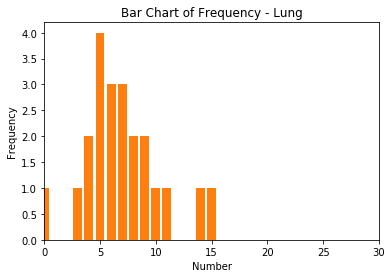

Number of KERs for AOP network of Lung: 136
Applying default style...
Applying preferred layout
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


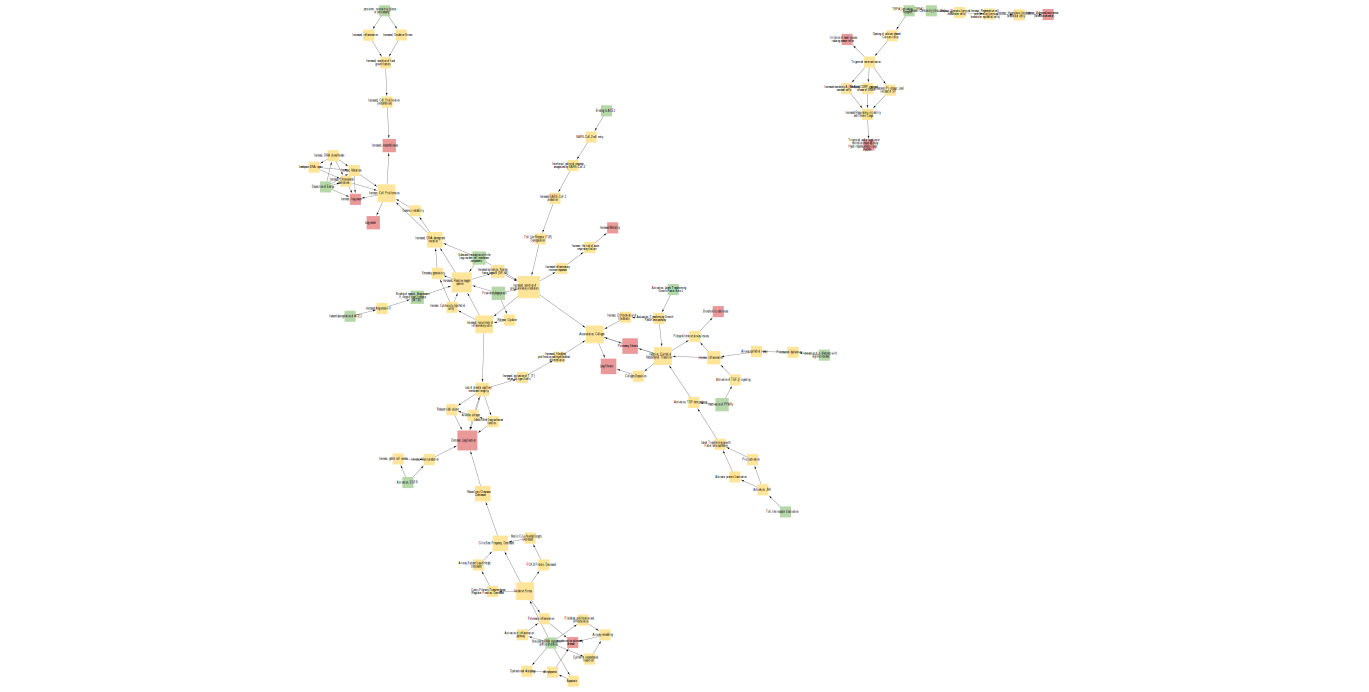

In [33]:
kertable = pd.DataFrame(columns=['KEup','KEdown'])

for item in organdict:
    nKE = {}
    chart_data = {}
    colorKE = {}
    print(item)
    kertable = pd.DataFrame(columns=['KEup','KEdown'])
    for AOP in organdict[item]:
        sparqlquery = '''select distinct ?KER ?KEup ?KEdown where {<'''+AOP+'''> a aopo:AdverseOutcomePathway ; aopo:has_key_event_relationship ?KER. ?KER aopo:has_upstream_key_event ?KEupid ; aopo:has_downstream_key_event ?KEdownid. ?KEupid dc:title ?KEup. ?KEdownid dc:title ?KEdown.}'''
        AOPWikiSPARQL.setQuery(sparqlquery)
        results = AOPWikiSPARQL.query().convert()
        x = []
        KEs = set()
        KEups = []
        KEdowns = []
        for result in results["results"]["bindings"]:
            x.append(result["KER"]["value"])
            kertable = kertable.append({
                'KEup': result["KEup"]["value"],
                'KEdown': result["KEdown"]["value"]
            }, ignore_index=True)
            
            KEs.add(result["KEup"]["value"])
            KEs.add(result["KEdown"]["value"])
            
            KEups.append(result["KEup"]["value"])
            KEdowns.append(result["KEdown"]["value"])
        for KEup in KEups:
            if KEup not in KEdowns:
                colorKE[KEup] = 'M'
            elif not KEup in colorKE:
                colorKE[KEup] = 'K'
            else:
                if not colorKE[KEup] == 'A' or 'M':
                    colorKE[KEup] = 'K'
        for KEdown in KEdowns:
            if KEdown not in KEups:
                colorKE[KEdown] = 'A'
            else:
                pass
                
        update_bar_chart(len(x),chart_data,item)
        print("The AOP ",AOP," has " + str(len(x)) + " KERs")
        for KE in KEs:
            if not KE in nKE:
                nKE[KE]=1
            else:
                nKE[KE]+=1
    print("Number of KEs in network of "+item+": "+str(len(colorKE)))
    # Create dictionary for size (corresponding with amount of times present in AOP-Wiki)
    for KE in nKE:
        nKE[KE]=(40+(10*nKE[KE]))
    
    # Create dataframe for size
    dfnKE = pd.DataFrame.from_dict(nKE, orient='index', columns=['Count'])
    
    # Create dataframe for color
    dfcolorKE = pd.DataFrame.from_dict(colorKE, orient='index', columns=['Color'])
    plt.savefig(str(item)+'-KEfreqplot.png')
    plt.show()
    
    kertable = kertable.drop_duplicates()
    print("Number of KERs for AOP network of " + item + ": "+str(len(kertable)))
    
    # Create nodes dataframe
    nodes = pd.DataFrame(data={'id': pd.concat([kertable['KEup'], kertable['KEdown']]).unique(), 'group': 'A', 'score': 20})

    # Create edges dataframe
    edges = pd.DataFrame(data={'source': kertable['KEup'], 'target': kertable['KEdown'], 'interaction': 'interacts', 'weight': 1 })
    
    # Create network
    p4c.create_network_from_data_frames(nodes, edges, title=item, collection="AOP Networks")
    
    # Assign count values as node attributes
    p4c.load_table_data(dfnKE)
    
    # Assign color values as node attributes
    p4c.load_table_data(dfcolorKE)
    
    # Map count attribute to node size in Cytoscape
    p4c.set_node_size_mapping('Count', mapping_type='passthrough')
    
    # Map color attribute to node size in Cytoscape
    p4c.set_node_color_mapping('Color', ['M', 'K', 'A'], ['#b6d7a8', '#ffe599', '#ea9999'], 'd')
    
    # Set node shape default
    p4c.set_node_shape_default('RECTANGLE')
    
    # Set arrow shape default
    p4c.set_edge_target_arrow_shape_default('ARROW')
    
    show_image_in_notebook(item+".svg")
    display(SVG(filename=organ+'.svg'))

### Exploring MIEs and stressors for organ-specific AOPs

In [24]:
for organ in organdict:
    print(organ)
    mietable = pd.DataFrame(columns=['MIEtitle','StressorNames','Chemicals'])
    for AOP in organdict[organ]:
        sparqlquery = '''select distinct ?MIEtitle (group_concat (distinct ?StressorName; separator=" | ") as ?StressorNames) (group_concat(distinct ?chemical; separator=" | ") as ?chemicals) 
where {<'''+AOP+'''> a aopo:AdverseOutcomePathway ; aopo:has_molecular_initiating_event ?MIE. 
        ?MIE dc:title ?MIEtitle .
        OPTIONAL {<'''+AOP+'''>  nci:C54571 ?Stressor . ?Stressor dc:title ?StressorName. OPTIONAL{?Stressor aopo:has_chemical_entity ?chemical. 
     }}}'''
        AOPWikiSPARQL.setQuery(sparqlquery)
        results = AOPWikiSPARQL.query().convert()
        for result in results["results"]["bindings"]:
            mietable = mietable.append({
                'MIEtitle': result["MIEtitle"]["value"],
                'StressorNames': result["StressorNames"]["value"],
                'Chemicals': result["chemicals"]["value"]
            }, ignore_index=True)         
    mietable.to_csv('output/'+organ+'-MIEs.tsv', sep='\t', index=False, encoding='utf-8')
    display(mietable)

Liver


,MIEtitle,StressorNames,Chemicals
0,"Activation, PXR/SXR",,
1,"Activation, Androgen receptor",,
2,"Increase, Cytotoxicity (hepatocytes)",,
3,"Inhibition, Fatty Acid Beta Oxidation",,
4,"Activation, Glucocorticoid Receptor",,
5,"Formation, Pro-mutagenic DNA Adducts",,
6,"Inhibition, Phospholipase A",,
7,NFE2/Nrf2 repression,NFE2/Nrf2 repression,
8,Endocytotic lysosomal uptake,3-aminopropanal | Chloroquine bis(phosphate) | Ciprofloxacin | Norfloxacin | ROS | artesunate | nanoparticles | o-methyl-serine dodecylamide hydrochloride (MSDH),https://identifiers.org/cas/50-63-5 | https://identifiers.org/cas/70458-96-7 | https://identifiers.org/cas/85721-33-1 | https://identifiers.org/cas/88495-63-0
9,Induced dysregulation of ACE2,,


Brain


,MIEtitle,StressorNames,Chemicals
0,"Increased, glucocorticoid receptor activity",Increase cortisone levels (induced by stress),
1,"Binding of agonist, Ionotropic glutamate receptors",,
2,CYP2E1 Activation,Acetaminophen | Chemical:584015 (1-~13~C)Aniline | Chlorzoxazone | Enflurane | Ethanol | Halothane | Isoflurane | Isoniazid | Methoxyflurane | Sevoflurane | Titanium oxide (TiO),https://identifiers.org/cas/103-90-2 | https://identifiers.org/cas/12137-20-1 | https://identifiers.org/cas/13838-16-9 | https://identifiers.org/cas/151-67-7 | https://identifiers.org/cas/26675-46-7 | https://identifiers.org/cas/28523-86-6 | https://identifiers.org/cas/54-85-3 | https://identifiers.org/cas/60-35-5 | https://identifiers.org/cas/64-17-5 | https://identifiers.org/cas/76-38-0 | https://identifiers.org/cas/95-25-0 | https://identifiers.org/cas/968-81-0
3,Protein Adduct Formation,Acetaminophen | Chemical:584015 (1-~13~C)Aniline | Chlorzoxazone | Enflurane | Ethanol | Halothane | Isoflurane | Isoniazid | Methoxyflurane | Sevoflurane | Titanium oxide (TiO),https://identifiers.org/cas/103-90-2 | https://identifiers.org/cas/12137-20-1 | https://identifiers.org/cas/13838-16-9 | https://identifiers.org/cas/151-67-7 | https://identifiers.org/cas/26675-46-7 | https://identifiers.org/cas/28523-86-6 | https://identifiers.org/cas/54-85-3 | https://identifiers.org/cas/60-35-5 | https://identifiers.org/cas/64-17-5 | https://identifiers.org/cas/76-38-0 | https://identifiers.org/cas/95-25-0 | https://identifiers.org/cas/968-81-0
4,"Inhibition, Na+/I- symporter (NIS)",,
5,"Increased, glucocorticoid receptor activity",Increase cortisone levels (induced by stress),
6,Binding to ACE2,,
7,"Binding at picrotoxin site, iGABAR chloride channel",Dieldrin | Endosulfan | Fipronil | Heptachlor | Lindane | Picrotoxin | RDX,https://identifiers.org/cas/115-29-7 | https://identifiers.org/cas/120068-37-3 | https://identifiers.org/cas/124-87-8 | https://identifiers.org/cas/58-89-9 | https://identifiers.org/cas/60-57-1 | https://identifiers.org/cas/76-44-8
8,Serotonin 1A Receptor Agonism,,
9,Binding of microtubule stabilizing agents (MSA) to microtubules,,


Kidney


,MIEtitle,StressorNames,Chemicals
0,"Alkylation, Protein",,
1,"Binding of substrate, endocytic receptor",Albumin | Aminoglycosides | Cadmium | Colistin | Gentamicin | Polymyxin B | Tobramycin | Vancomycin | low molecular weight proteins,https://identifiers.org/cas/1066-17-7 | https://identifiers.org/cas/1403-66-3 | https://identifiers.org/cas/1404-26-8 | https://identifiers.org/cas/1404-90-6 | https://identifiers.org/cas/308060-74-4 | https://identifiers.org/cas/32986-56-4 | https://identifiers.org/cas/7440-43-9
2,"Inhibition, organic anion transporter 1 (OAT1)",,
3,"Oxidation, Glutathione (To be considered with MIE)","Arsenic | Bis(2,4,6-trimethylphenyl)-lambda~2~-germane--selenium (1/1) | Uranium",https://identifiers.org/cas/115385-04-1 | https://identifiers.org/cas/7440-38-2 | https://identifiers.org/cas/7440-61-1
4,Inhibition of mitochondrial DNA polymerase gamma (Pol gamma),Adefovir | Adefovir dipivoxil | Cidofovir | Tenofovir | Tenofovir disoproxil fumarate,https://identifiers.org/cas/106941-25-7 | https://identifiers.org/cas/113852-37-2 | https://identifiers.org/cas/142340-99-6 | https://identifiers.org/cas/147127-20-6 | https://identifiers.org/cas/202138-50-9
5,"Binding, Thiol/seleno-proteins involved in protection against oxidative stress",,
6,"Activation, 5HT2c",,
7,"Increase, Cytotoxicity (tubular epithelial cells)",,
8,"Binding of inhibitor, NADH-ubiquinone oxidoreductase (complex I)",,
9,"Inhibition, Cyclooxygenase 1 activity",Carprofen | Celecoxib | Clofibrate | Diclofenac sodium | Ibuprofen | Indomethacin | Ketoprofen | Meloxicam | Phenylbutazone | flunixin meglumine | nimesulide,https://identifiers.org/cas/15307-79-6 | https://identifiers.org/cas/15687-27-1 | https://identifiers.org/cas/169590-42-5 | https://identifiers.org/cas/22071-15-4 | https://identifiers.org/cas/42461-84-7 | https://identifiers.org/cas/50-33-9 | https://identifiers.org/cas/51803-78-2 | https://identifiers.org/cas/53-86-1 | https://identifiers.org/cas/53716-49-7 | https://identifiers.org/cas/637-07-0 | https://identifiers.org/cas/71125-38-7


Lung


,MIEtitle,StressorNames,Chemicals
0,Inhibition of lung surfactant function,,
1,"Increase, Cytotoxicity (club cells)",,
2,"TRPA1 activation, TRPA1 Receptor","2-Chlorobenzalmalononitrile | Dibenzo[B,F][1,4]Oxazepine",
3,Oxidative Stress,Acrolein | Cigarette smoke | Diesel engine exhaust | Nitrogen dioxide | Ozone,NOCAS | https://identifiers.org/cas/10028-15-6 | https://identifiers.org/cas/10102-44-0 | https://identifiers.org/cas/107-02-8
4,"Activation, Latent Transforming Growth Factor Beta 1",Carbon nanotubes,
5,Oxidative Stress,Cigarette smoke,NOCAS
6,Oxidative Stress,Acrolein | Cigarette smoke | Ozone,NOCAS | https://identifiers.org/cas/10028-15-6 | https://identifiers.org/cas/107-02-8
7,Inactivation of PPARγ,,
8,Toll-like receptor 4 activation,,
9,Non-coding RNA expression profile alteration,,


## Metadata

In [12]:
%load_ext watermark
%watermark -v -m -p sys,re,requests,py4cytoscape,SPARQLWrapper

CPython 3.7.16
IPython 7.6.1

sys 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
re 2.2.1
requests 2.28.1
py4cytoscape 0.0.8
SPARQLWrapper 1.8.2

compiler   : GCC 11.2.0
system     : Linux
release    : 5.4.0-94-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [13]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.1.0',
 'py4cytoscapeVersion': '0.0.8'}